In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

from keras.layers import Conv2D, PReLU, BatchNormalization,Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm #progess bar
from keras.applications.vgg19 import VGG19

In [2]:

train_dir = "H:/python3/pythonProject/venv/AIP_Project/Gan_SuperRes/train_dir"

# for img in os.listdir(train_dir +"/original_images/mirflickr25k/mirflickr"):
#     img_array = cv2.imread(train_dir + "/original_images/mirflickr25k/mirflickr/" + img)

#     img_array = cv2.resize(img_array, (1024,1024))
#     lr_img_array = cv2.GaussianBlur(img_array,(5,5),0)
#     lr_img_array = cv2.resize(img_array,(256,256))
#     cv2.imwrite(train_dir+"/hr_images/"+img,img_array)
#     cv2.imwrite(train_dir+"/lr_images/"+img,lr_img_array)

In [3]:
#Generator

def res_block(ip):
    res_model = Conv2D(256,(5,5), padding="same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = Conv2D(256, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(256, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return res_model

def upscale_block(ip):

    up_model = Conv2D(1024, (3,3), padding="same")(ip)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    up_model = Conv2D(1024, (3,3), padding="same")(up_model)
    up_model = BatchNormalization(momentum=0.5)(up_model)
    up_model = UpSampling2D(size=2)(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    return up_model

def create_gen(gen_ip, num_res_block):
    
    layers = Conv2D(256, (9,9),padding = "same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)
    layers = Conv2D(256, (5,5),padding = "same")(layers)
    layers = PReLU(shared_axes=[1,2])(layers)

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(256, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)



In [4]:
# Discriminator

def discriminator_block(ip, filters, strides=1, bn=True):
    disc_model = Conv2D(filters, (3,3) ,strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8)(disc_model)

    disc_model = LeakyReLU( alpha=0.3)(disc_model)

    return disc_model

def create_disc(disc_ip):
    # create dis
    df = 40

    d1 = discriminator_block(disc_ip, df , bn = False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides = 2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.3)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [5]:
# Combination

def build_vgg(hr_shape):
    
    # combine many vgg layers to get more specific image
    selectedLayers = [10,15,2,5]
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    selectedOutputs = [vgg.layers[i].output for i in selectedLayers]

    return Model(inputs=vgg.inputs, outputs=selectedOutputs)

def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [9]:
# Load data

n=25000
lr_list = os.listdir(train_dir + "/lr_images")[:n]

# lr_images = []
# for img in lr_list:
#     img_lr = cv2.imread("lr_images/"+img)
#     img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
#     lr_images.append(img_lr)
lr_image_urls = []
for url in lr_list:
    lr_image_urls.append(str(train_dir + "/lr_images/" + url))

hr_list = os.listdir(train_dir + "/hr_images")[:n]

# hr_images = []
# for img in hr_list:
#     img_hr = cv2.imread("hr_images/"+img)
#     img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
#     hr_images.append(img_hr)
hr_image_urls = []
for url in lr_list:
    hr_image_urls.append(str(train_dir + "/hr_images/" + url))

# lr_images = np.array(lr_images)
# hr_images = np.array(hr_images)

#Plot random lr and hr image
# import random
# import numpy as np
# image_number = random.randint(0,len(lr_images)-1)
# plt.figure(figsize=(12,6))
# plt.subplot(121)
# plt.imshow(np.reshape(lr_images[image_number],(32,32,3)))
# plt.subplot(122)
# plt.imshow(np.reshape(hr_images[image_number],(128,128,3)))
# plt.show()

# lr_images = lr_images/255
# hr_images = hr_images/255

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_image_urls, hr_image_urls,test_size=0.03,random_state=True)

# hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
# lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

hr_shape = (256,256,3)
lr_shape = (64,64,3)

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


In [10]:
# hr_image_urls

In [11]:
# Model
import h5py

generator = create_gen(lr_ip, num_res_block=20)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((1024,1024,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator,discriminator,vgg,lr_ip,hr_ip)


gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3,1],optimizer="adam")
gan_model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_76 (Conv2D)          (None, 64, 64, 256)       62464     
                                                                 
 p_re_lu_26 (PReLU)          (None, 64, 64, 256)       256       
                                                                 
 conv2d_77 (Conv2D)          (None, 64, 64, 256)       1638656   
                                                                 
 p_re_lu_27 (PReLU)          (None, 64, 64, 256)       256       
                                                                 
 conv2d_78 (Conv2D)          (None, 64, 64, 256)       1638656   
                                                                 
 batch_normalization_70 (Bat  (None, 64, 64, 256)      1024

                                                                 
 p_re_lu_34 (PReLU)          (None, 64, 64, 256)       256       
                                                                 
 conv2d_98 (Conv2D)          (None, 64, 64, 256)       590080    
                                                                 
 batch_normalization_90 (Bat  (None, 64, 64, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_99 (Conv2D)          (None, 64, 64, 256)       1638656   
                                                                 
 batch_normalization_91 (Bat  (None, 64, 64, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_100 (Conv2D)         (None, 64, 64, 256)       590080    
                                                                 
 batch_nor

 tchNormalization)                                               
                                                                 
 conv2d_120 (Conv2D)         (None, 64, 64, 256)       1638656   
                                                                 
 batch_normalization_112 (Ba  (None, 64, 64, 256)      1024      
 tchNormalization)                                               
                                                                 
 conv2d_121 (Conv2D)         (None, 64, 64, 256)       590080    
                                                                 
 batch_normalization_113 (Ba  (None, 64, 64, 256)      1024      
 tchNormalization)                                               
                                                                 
 p_re_lu_42 (PReLU)          (None, 64, 64, 256)       256       
                                                                 
 conv2d_122 (Conv2D)         (None, 64, 64, 256)       590080    
          

 p_re_lu_50 (PReLU)          (None, 128, 128, 1024)    1024      
                                                                 
 conv2d_142 (Conv2D)         (None, 128, 128, 1024)    9438208   
                                                                 
 batch_normalization_132 (Ba  (None, 128, 128, 1024)   4096      
 tchNormalization)                                               
                                                                 
 up_sampling2d_3 (UpSampling  (None, 256, 256, 1024)   0         
 2D)                                                             
                                                                 
 p_re_lu_51 (PReLU)          (None, 256, 256, 1024)    1024      
                                                                 
 conv2d_143 (Conv2D)         (None, 256, 256, 3)       248835    
                                                                 
Total params: 89,671,683
Trainable params: 89,636,355
Non-trainable params: 

_________________________________________________________________
None
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 256, 256, 3)  89671683    ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)

In [ ]:
# TRAINING

# Custom batch of data
batch_size = 1
train_lr_batches = []
train_hr_batches = []

for it in range(int(len(hr_train)/batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

epochs = 5


for e in range(epochs):
    fake_label = np.zeros((batch_size,1))
    real_label = np.ones((batch_size,1))

    g_losses = []
    d_losses = []

    for b in tqdm(range(len(train_hr_batches))):
      #......
        lr_image_urls = train_lr_batches[b]
        lr_images = cv2.imread("".join(lr_image_urls))
        lr_images = np.array(lr_images)
        lr_images = cv2.cvtColor(lr_images, cv2.COLOR_BGR2RGB)
        lr_images = lr_images/255

        hr_image_urls = train_hr_batches[b]
        hr_images = cv2.imread("".join(hr_image_urls))
        hr_images = np.array(hr_images)
        hr_images = cv2.cvtColor(hr_images, cv2.COLOR_BGR2RGB)
        hr_images = hr_images/255

        lr_images = np.expand_dims(lr_images, axis=0)
        hr_images = np.expand_dims(hr_images,axis=0)
#...
        fake_imgs = generator.predict_on_batch(lr_images)

        discriminator.trainable = True
        d_losses_gen = discriminator.train_on_batch(fake_imgs,fake_label)
        d_losses_real = discriminator.train_on_batch(hr_images,real_label)

        discriminator.trainable = False

        d_loss = 0.5 + np.add(d_losses_gen, d_losses_real)
        image_features = vgg.predict(hr_images)

        g_loss, _, _ = gan_model.train_on_batch([lr_images, hr_images],[real_label, image_features])

        d_losses.append(d_loss)
        g_losses.append(g_loss)

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    g_loss = np.sum(g_losses, axis=0)/ len(g_losses)
    d_loss = np.sum(d_losses,axis=0) / len(d_losses)

    print("epoch:", e+1, "g_loss:", g_loss, "d_loss:", d_loss)

    generator.save("gen_e_"+str(e+1)+" "+str(g_loss)+" "+str(n)+" "+str(d_loss)+".h5")



In [ ]:

#Imageflow
# filepath = "Treeweights-{epoch:82d}-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
# callbacks_list = [checkpoint]
#
# aug = ImageDataGenerator(rotation_range=20, zoom_range=0.2,
#      rescale=1./255,
#     width_shift_range=0.1,
#       height_shift_range=0.1,
#   	horizontal_flip=True,
#      brightness_range=[0.5,2.5], fill_mode="nearest")
#
# aug_val = ImageDataGenerator(rescale=1./255)

#Fit_model
# vgghist=vggmodel.fit_generator(aug.flow(x_train, y_train, batch_size=64),
#                                  epochs=50,
#                                  validation_data=aug.flow(x_test,y_test,
#                                  batch_size=64),
#                                  callbacks=callbacks_list)


#Load weights
# generator = create_gen(lr_ip, num_res_block=16)
# generator.summary()
#
# discriminator = create_disc(hr_ip)
# discriminator.compile(loss="binary_crossentopy",optimizer="adam",metrics=['accuracy'])
# discriminator.summary()
#
# vgg = build_vgg((128,128,3))
# print(vgg.summary())
# vgg.trainable = False
#
# gan_model = create_comb(generator,discriminator,vgg,lr_ip,hr_ip)
# gan_model.load_weights()



2874
1/1 [==============================] - 2s 2s/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_13704\1619755838.py:58: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(ip_img, ref_img, multichannel=multi)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


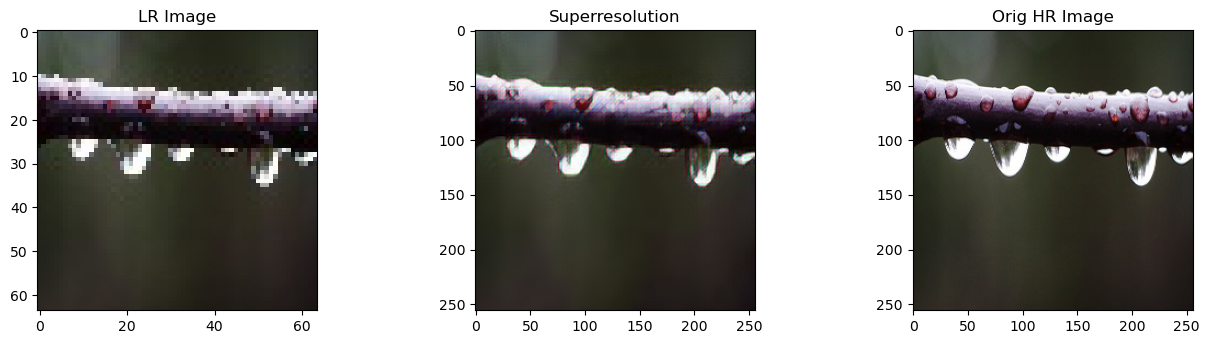

In [33]:
from keras.models import load_model
from numpy.random import randint
import cv2
import matplotlib.pyplot as plt
from CustomPadding import SymmetricPadding2D
from skimage import exposure

train_dir = "H:/python3/pythonProject/venv/AIP_Project/Gan_SuperRes/train_dir"

# using the best optimized generator
generator = load_model('H:\Deep_Learning\gen_e_12 23.80226371314068 25000 [0.59059704 2.49955556].h5', compile=False, custom_objects={"SymmetricPadding2D": SymmetricPadding2D})

# [x1,x2] = [lr_test,hr_test]
#

# One image URL
# src_image = cv2.imread('7cdb08db873944671d28logo.jpg')
# src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
# src_image = src_image/255
# src_image = src_image.reshape((1,32,32,3))

# tar_image = cv2.imread('7cdb08db873944671d28logohr.jpg')
# tar_image = cv2.cvtColor(tar_image, cv2.COLOR_BGR2RGB)
# tar_image = tar_image/255
# tar_image = tar_image.reshape((1,128,128,3))

# Index image from trainning and testing

# if cv2.waitKey(1) == ord('q'):
#     break

#random image 
ix = randint(0, 24999,1)

# ix =11151

# normalize image
print(str(int(ix)))
src_image = cv2.imread( train_dir + "/lr_images/" + 'im' + str(int(ix)) +'.jpg')
src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
src_image = src_image/255
src_image = src_image.reshape((1,64,64,3))
tar_image = cv2.imread( train_dir +"/hr_images/" + 'im' + str(int(ix)) +'.jpg')
tar_image = cv2.cvtColor(tar_image, cv2.COLOR_BGR2RGB)
tar_image = tar_image/255
tar_image = tar_image.reshape((1,256,256,3))

# generator return the image with mismatched colors
# matching the color of img with ref 
def matchHistogram(img, ref):
    # img = cv2.cvtColor(img , cv2.COLOR_RGB2BGR)
    # ref = cv2.cvtColor(np.float32(ref) * 255, cv2.COLOR_RGB2BGR)
    output = np.zeros(img.shape)
    ip_img = cv2.normalize(img, output, 30, 255, cv2.NORM_MINMAX)
    ref_img = cv2.normalize(ref, output, 30, 255, cv2.NORM_MINMAX)

    multi = True if img.shape[-1] > 1 else False
    matched = exposure.match_histograms(ip_img, ref_img, multichannel=multi)
    matched = cv2.normalize(matched, output, 0, 255, cv2.NORM_MINMAX)
    matched = matched / 255

    return matched
 

gen_image = generator.predict(src_image)

matched_img = matchHistogram(gen_image, src_image)

plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(matched_img[0,:,:,:])
plt.subplot(233)
plt.title('Orig HR Image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [10]:
# This notebook is followed the MIT License